### Penguins dataset: K Nearest Neighbors Classifier (KNN)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split

In [2]:
import seaborn as sns
df = sns.load_dataset("penguins")

### 1. find/remove rows with Nan's in any column except sex

In [3]:
df.drop(df[df.iloc[:, :-1].isna().any(axis = 1)].index, axis = 0, inplace = True)

### 2. infer gender based on all attributes

In [4]:
# get dataframe with dummies
df_dumm = pd.get_dummies(df, columns = ['species', 'island'])

In [5]:
# reference dataframe
Y_train = df_dumm[df_dumm.sex.notna()].reset_index(drop = True)
# reference matrix
Y = Y_train.loc[:, df_dumm.dtypes != 'object'].to_numpy()

In [6]:
def inferSex_(row):
    y = row.loc[df_dumm.dtypes != 'object'].to_numpy()
    nny = np.argmin(np.sum((y -Y)**2, axis = 1))
    return Y_train.sex.iloc[nny]

In [7]:
df['sex'] = df_dumm.apply(inferSex_, axis = 1)

### 3. Feature space

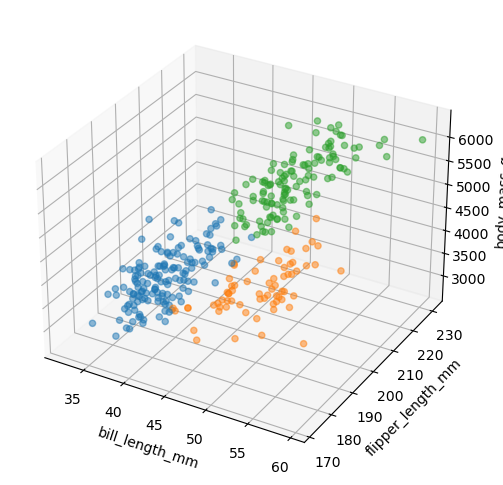

In [8]:
cols = df.columns[[2, 4, 5]]
# 3D scatter plot
fig = plt.figure(figsize = (6, 6))
axs = fig.add_subplot(projection = '3d')
# get colormap from seaborn
cmap = ListedColormap(sns.color_palette().as_hex()[:3])
# 
s3d = axs.scatter(df[cols[0]], df[cols[1]], df[cols[2]], c = df.species.factorize()[0], cmap = cmap, marker = 'o', s = 20, alpha = 0.5)
axs.set_xlabel(cols[0])
axs.set_ylabel(cols[1])
axs.set_zlabel(cols[2]);

### 4. make inference using only numerical information

#### train/test split

In [9]:
df.head(3)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female


In [10]:
X_train, X_test = train_test_split(df, test_size = 0.2, random_state = 2873)
X_train.head(3)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
25,Adelie,Biscoe,35.3,18.9,187.0,3800.0,Female
240,Gentoo,Biscoe,50.2,14.3,218.0,5700.0,Male
44,Adelie,Dream,37.0,16.9,185.0,3000.0,Female


In [11]:
# reference matrix
X = X_train.loc[:, X_train.dtypes != 'object'].to_numpy(dtype = 'float')
X

array([[  35.3,   18.9,  187. , 3800. ],
       [  50.2,   14.3,  218. , 5700. ],
       [  37. ,   16.9,  185. , 3000. ],
       ...,
       [  47.2,   13.7,  214. , 4925. ],
       [  44.9,   13.8,  212. , 4750. ],
       [  46.5,   14.8,  217. , 5200. ]])

In [12]:
# inference function
def getNN(row, predict, k = 5):
    y = row[X_test.dtypes != 'object'].to_numpy(dtype = 'float') # X_test.dtypes != 'object' !!!
    X_train['d2x'] = np.sqrt(np.sum((y -X)**2, axis = 1))
    return X_train.sort_values(by = 'd2x')[:k][predict].value_counts().index[0]

In [13]:
# test inference function with random test values
getNN(X_test.iloc[np.random.randint(0, X_test.shape[0])], 'species')

'Gentoo'

##### classify species for test examples

In [14]:
# run inference function over the test set
predict = 'species'
X_test['predicted'] = X_test.apply(lambda t: getNN(t, predict, k = 5), axis = 1)
# show result
X_test.groupby(predict).predicted.value_counts()

species    predicted
Adelie     Adelie       29
           Gentoo        4
           Chinstrap     2
Chinstrap  Adelie        6
           Chinstrap     3
Gentoo     Gentoo       24
           Adelie        1
Name: predicted, dtype: int64

##### classify island for test examples

In [15]:
# run inference function over the test set
predict = 'island'
X_test['predicted'] = X_test.apply(lambda t: getNN(t, predict, k = 5), axis = 1)
# show result
X_test.groupby(predict).predicted.value_counts()

island     predicted
Biscoe     Biscoe       28
           Dream         8
Dream      Dream        16
           Biscoe        2
           Torgersen     2
Torgersen  Dream         9
           Biscoe        3
           Torgersen     1
Name: predicted, dtype: int64

##### classify gender for test examples

In [16]:
# run inference function over the test set
predict = 'sex'
X_test['predicted'] = X_test.apply(lambda t: getNN(t, predict), axis = 1)
# show result
X_test.groupby(predict).predicted.value_counts()

sex     predicted
Female  Female       29
        Male          2
Male    Male         22
        Female       16
Name: predicted, dtype: int64

### 5. make inference using all information

In [17]:
# split train/test
Y_train, Y_test = train_test_split(df, test_size = 0.2, random_state = 2873)
Y_train.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
25,Adelie,Biscoe,35.3,18.9,187.0,3800.0,Female
240,Gentoo,Biscoe,50.2,14.3,218.0,5700.0,Male
44,Adelie,Dream,37.0,16.9,185.0,3000.0,Female
104,Adelie,Biscoe,37.9,18.6,193.0,2925.0,Female
318,Gentoo,Biscoe,48.4,14.4,203.0,4625.0,Female


In [18]:
# add parameters for reference matrix and attribute to predict
def getNN_(row, Y, predict, k = 5):
    y = row.to_numpy(dtype = 'float')
    Y_train['d2x'] = np.sqrt(np.sum((y -Y)**2, axis = 1))
    return Y_train.sort_values(by = 'd2x')[:k][predict].value_counts().index[0]

##### classify species

In [19]:
# select attribute to predict
predict = 'species'
# reference matrix
Y = pd.get_dummies(Y_train.drop(predict, axis = 1)).to_numpy()
# test data frame
test = pd.get_dummies(Y_test.drop(predict, axis = 1))
# run inference function over the test set
Y_test['predicted'] = test.apply(lambda row: getNN_(row, Y, predict, k = 5), axis = 1)
# show result
Y_test.groupby(predict).predicted.value_counts()

species    predicted
Adelie     Adelie       29
           Gentoo        4
           Chinstrap     2
Chinstrap  Adelie        6
           Chinstrap     3
Gentoo     Gentoo       24
           Adelie        1
Name: predicted, dtype: int64

In [20]:
# compare with previous prediction
X_test['predicted'] = X_test.apply(lambda t: getNN(t, predict), axis = 1)
X_test.groupby(predict).predicted.value_counts()

species    predicted
Adelie     Adelie       29
           Gentoo        4
           Chinstrap     2
Chinstrap  Adelie        6
           Chinstrap     3
Gentoo     Gentoo       24
           Adelie        1
Name: predicted, dtype: int64

##### classify island

In [21]:
# clean previous prediction
Y_train.drop('d2x', axis = 1, inplace = True)
Y_test.drop('predicted', axis = 1, inplace = True)

In [22]:
# select attribute to predict
predict = 'island'
# reference matrix
Y = pd.get_dummies(Y_train.drop(predict, axis = 1)).to_numpy()
# test data frame
test = pd.get_dummies(Y_test.drop(predict, axis = 1))
# run inference function over the test set
Y_test['predicted'] = test.apply(lambda row: getNN_(row, Y, predict, k = 5), axis = 1)
# show result
Y_test.groupby(predict).predicted.value_counts()

island     predicted
Biscoe     Biscoe       28
           Dream         8
Dream      Dream        16
           Biscoe        2
           Torgersen     2
Torgersen  Dream         9
           Biscoe        3
           Torgersen     1
Name: predicted, dtype: int64

In [23]:
# compare with previous prediction
X_test['predicted'] = X_test.apply(lambda t: getNN(t, predict), axis = 1)
X_test.groupby(predict).predicted.value_counts()

island     predicted
Biscoe     Biscoe       28
           Dream         8
Dream      Dream        16
           Biscoe        2
           Torgersen     2
Torgersen  Dream         9
           Biscoe        3
           Torgersen     1
Name: predicted, dtype: int64

##### classify gender

In [24]:
# clean previous prediction
Y_train.drop('d2x', axis = 1, inplace = True)
Y_test.drop('predicted', axis = 1, inplace = True)

In [25]:
# select attribute to predict
predict = 'sex'
# reference matrix
Y = pd.get_dummies(Y_train.drop(predict, axis = 1)).to_numpy()
# test data frame
test = pd.get_dummies(Y_test.drop(predict, axis = 1))
# run inference function over the test set
Y_test['predicted'] = test.apply(lambda row: getNN_(row, Y, predict, k = 5), axis = 1)
# show result
Y_test.groupby(predict).predicted.value_counts()

sex     predicted
Female  Female       29
        Male          2
Male    Male         22
        Female       16
Name: predicted, dtype: int64

In [26]:
# compare with previous prediction
X_test['predicted'] = X_test.apply(lambda t: getNN(t, predict), axis = 1)
X_test.groupby(predict).predicted.value_counts()

sex     predicted
Female  Female       29
        Male          2
Male    Male         22
        Female       16
Name: predicted, dtype: int64